# <p style = text-align: center>Estudo de Caso - Modelo preditivo para cancelamento de reservas de Hotel

<a id = '0'></a>
### Conteúdo:
* [1. Objetivo do modelo](#1.0)
* [2. Expectativas iniciais](#2.0)
* [3. Importação e exploração de dados](#3.0)
    * [3.1 Importação das bibliotecas](#3.1)
    * [3.2 Importação da base de dados](#3.2)
    * [3.3 Entendimento inicial dos dados](#3.3)
    * [3.4 Análise exploratória dos dados](#3.4)
    * [3.5 Tratamento de outliers](#3.5)
        * [3.5.1 Método de Turkey para tratamento de outliers de colunas numéricas](#3.5.1)
        * [3.5.2 Colunas com texto/categóricas](#3.5.2)        
* [4. Modelo de previsão](#4.0)
    * [4.1 Estruturando o modelo](#4.1)
    * [4.2 Gerando a previsão](#4.2)    
* [5. Considerações finais](#5.0)

<a id='1.0'></a>
### 1.  Objetivo do Modelo

Criar um modelo que possa prever se uma reserva será cancelada ou não pelo cliente.

<a id = '2.0'></a>
### 2. Expectativas iniciais

A partir da leitura do artigo "Hotel booking demand datasets", que traz a descrição da base de dados e de todas as suas variáveis, segue algumas expectativas/pensamentos iniciais que obtive:
- Acredito que quanto mais dias um pedido de reserva fica na lista de espera para ser aprovado, maior a probabilidade dele ser cancelado visto que dá mais tempo para o cliente mudar de ideia.
- Intuitivamente, espera-se também que um cliente com histórico de cancelamentos tenha a tendência de efetuar novos cancelamentos.
- Em contrapartida ao ponto anterior, pode ser que clientes antigos tenham menor tendência em cancelar suas reservas visto que conhecem os processos de agendamento e foram fidelizados por algum motivo.
- Para aplicação do modelo no Hurb, entende-se que variáveis como a data escolhida para a reserva e o não entendimento do Regulamento de Hotéis (por parte do cliente) possam ser significativos.

<a id = '3.0'></a>
### 3. Importação e exploração de dados

<a id = '3.1'></a>
#### 3.1 Importação das Bibliotecas

In [1]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix

<a id = '3.2'></a>
#### 3.2 Importação da Base de Dados

In [2]:
df = pd.read_csv("hotel_bookings.csv")

# Primeira visualização nos dados
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


<a id = '3.3'></a>
#### 3.3 Entendimento inicial dos dados

In [3]:
# Dados estatísticos de cada coluna do dataframe
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


A partir da contagem de dados de cada coluna ("count"), percebe-se que as colunas "agent" e "company" não possuem todas as linhas preenchidas, provavelmente por conta desses campos não serem aplicáveis para todos os exemplos.

In [4]:
# Print da taxa de valores vazios/NaN por coluna
print(df.isnull().sum()/len(df))

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

Conforme verificado anteriormente, as colunas "company" e "agent" possuem muitos dados faltantes (mais de 10% do total). Portanto, tirarei essas colunas para não atrapalhar a previsão do modelo.

As colunas "country" e "children" também possuem linhas vazias, porém em menor quantidade (menor que 1%). Neste caso, preencherei essas linhas com os valores mais frequentes de cada coluna: "PRT" e "0", respectivamente.

In [5]:
# Drop das colunas "agent" e "company"
df.drop(["agent", "company"], axis = 'columns', inplace = True)

In [6]:
# Preenchendo valores em branco das colunas "contry" e "children" com o valor que mais se repete em cada campo
df['country'] = df['country'].fillna('PRT')
df['children'] = df['children'].fillna(0)

print(df.isnull().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [7]:
# Verificando o tipo de dado de cada coluna
print(df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list              

In [8]:
# Ajustando o tipo de dado da coluna "children" para Inteiros
df['children'] = df['children'].astype(np.int64)

In [9]:
# Convertendo a coluna de meses para Inteiros (Jan = 1, Fev = 2, ...)
dt = df['arrival_date_month'].str[0:3]
numero_mes = np.zeros(len(dt))
for i in range (0, len(dt)):
    dt[i] = datetime.strptime(dt[i], "%b")
    numero_mes[i] = dt[i].month
    
# Transformando os dados de mês em inteiro
numero_mes = pd.DataFrame(numero_mes).astype(int)

# Unindo as colunas de data em uma só
df['data_chegada'] = df['arrival_date_year'].map(str) + '-' + numero_mes[0].map(str) + '-' + df['arrival_date_day_of_month'].map(str)

In [10]:
# Drop das antigas colunas referentes a data
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_week_number'], axis = 1)

Vou assumir que as reservas de hotel que possuem 0 adultos são devido a erro de registro no sistema, visto que crianças e bebês não reservariam um quarto de hotel sozinhas.

In [11]:
# Eliminando linhas com valor 0 na coluna "adulto"
print(df.shape)
erro_adulto = df.adults == 0
df = df[~erro_adulto]
print(df.shape)

df.head()

(119390, 27)
(118987, 27)


,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,data_chegada
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,...,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,...,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,...,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,...,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-7-1


<a id = '3.4'></a>
#### 3.4 Análise exploratória de dados

A etapa de exploração de dados é importante para aprender os padrões de comportamento das nossas features e, principalmente, como elas se relacionam com a nossa variável target ("is_canceled").

Nesta etapa, seguirei os seguintes pontos:
1. Verificar correlação entre as features numéricas.
2. Entender relação que certas variáveis categóricas possuem com a variável target.
3. Confirmar se todas as features que temos realmente fazem sentido para o modelo. Caso contrário, pode ser necessário excluir para dar maior eficiência ao modelo.

<AxesSubplot:>

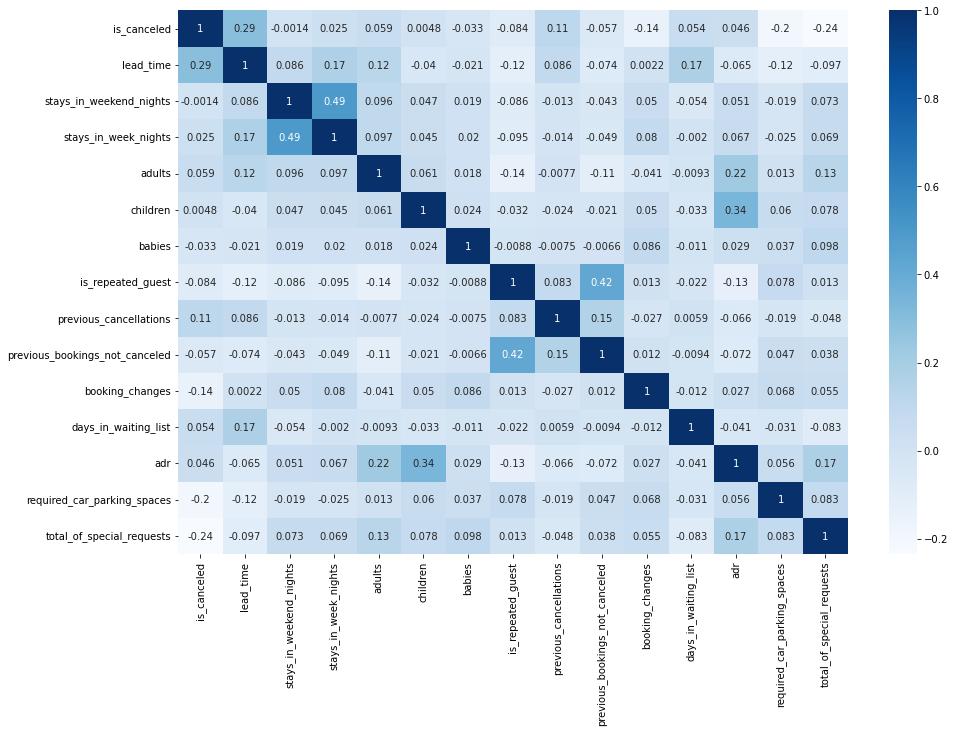

In [12]:
# Mapa de calor com correlação entre todas as variáveis
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')

In [13]:
# Coeficiente de correlação da variável target 'is_canceled' com o restante das features
correlacao = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlacao

is_canceled                       1.000000
lead_time                         0.292983
total_of_special_requests         0.235262
required_car_parking_spaces       0.195863
booking_changes                   0.144863
previous_cancellations            0.110222
is_repeated_guest                 0.083797
adults                            0.058891
previous_bookings_not_canceled    0.057413
days_in_waiting_list              0.054357
adr                               0.046460
babies                            0.032620
stays_in_week_nights              0.025348
children                          0.004837
stays_in_weekend_nights           0.001388
Name: is_canceled, dtype: float64

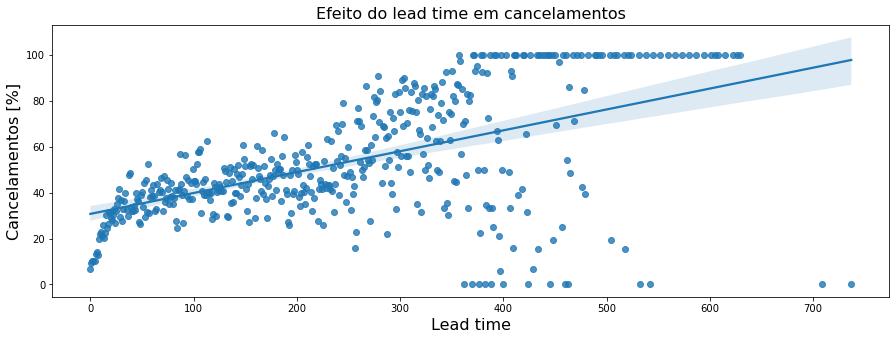

In [14]:
# Efeito do lead time em cancelamentos
lead_time_cancel = df.groupby("lead_time")['is_canceled'].describe()

# gráfico
plt.figure(figsize=(15, 5))
sns.regplot(x=lead_time_cancel.index, y=lead_time_cancel["mean"].values * 100)
plt.title("Efeito do lead time em cancelamentos", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelamentos [%]", fontsize=16)
plt.show()

A partir do mapa de calor é possível ter **maior entendimento sobre como as variáveis se comportam entre si**.

Um insight retirado daqui, por exemplo, é que **a feature com maior grau de relação com o fato de uma reserva ser cancelada ou não é a de "lead_time"**, ou seja, quanto maior o tempo existente entre a reserva do hotel até a chegada no mesmo, maior a probabilidade de haver cancelamento.

No tópico "Expectativas Inicias", desta documentação, também pontuei o histórico de cancelamentos do cliente (coluna "previous_cancellations" no caso desse dataset) como um possível fator significativo. Olhando a correlação, é possível verificar que essa relação realmente é válida, apresentando um grau de relação de 11% com a varíavel target.

Se o mapa de calor apresentasse colunas com correlação forte (próximo de 1, por exemplo), eu provavelmente faria a exclusão de uma delas para não enviesar o resultado do modelo.

Por outro lado, deve-se analisar com cuidado a utilidade de colunas com correlação fraca (próximo de 0) e, se for o caso, as mesmas devem ser excluídas.

Colunas a serem retiradas do modelo:
- country: Por se tratar de hotéis Portugueses, não temos um número significativo de brasileiros registrados, e o fator de "generalização" do modelo seria perdido.
- assigned_room_type: Pois já existe a coluna "reserved_room_type", que é similar, e que nos retorna o quarto que de fato foi reservado.
- days_in_waiting_list: a maior parte dos dados dessa coluna é 0 (poucos dias de espera). Além disso, acredito que o 'lead time' já seja uma feature mais efetiva para duração de processo.
- reservation_status: tem função similar à variável target.
- reservation_status_date: como excluiremos a "reservation_status" esta coluna perde seu valor.

OBS.: Foi considerada a concatenação entre os valores das colunas 'children' e 'babies' nesse processo de feature engineering, visto que se avaliou uma possível dificuldade do processo em diferenciar crianças de bebês. Entretanto, a coluna resultante dessa soma apresentou um resultado ruim de correlação com a variável target.

In [15]:
# Colunas numéricas a serem retiradas
colunas = ['country', 'assigned_room_type', 'days_in_waiting_list', 'reservation_status', 'reservation_status_date']
df.drop(colunas, axis = 1, inplace = True)

df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,data_chegada
0,Resort Hotel,0,342,0,0,2,0,0,BB,Direct,...,0,0,C,3,No Deposit,Transient,0.0,0,0,2015-7-1
1,Resort Hotel,0,737,0,0,2,0,0,BB,Direct,...,0,0,C,4,No Deposit,Transient,0.0,0,0,2015-7-1
2,Resort Hotel,0,7,0,1,1,0,0,BB,Direct,...,0,0,A,0,No Deposit,Transient,75.0,0,0,2015-7-1
3,Resort Hotel,0,13,0,1,1,0,0,BB,Corporate,...,0,0,A,0,No Deposit,Transient,75.0,0,0,2015-7-1
4,Resort Hotel,0,14,0,2,2,0,0,BB,Online TA,...,0,0,A,0,No Deposit,Transient,98.0,0,1,2015-7-1


Entenderei agora a relação de algumas variáveis categóricas com a variável target.

C:\Users\joaov\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


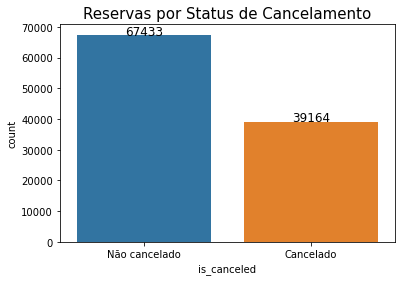

In [47]:
# Proporção de reservas canceladas x não canceladas
canceled_data = df['is_canceled']
plot = sns.countplot(canceled_data)
plt.title('Reservas por Status de Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Não cancelado', 'Cancelado'])
for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

plt.show()

Os hotéis da base de dados apresentaram uma taxa de cancelamentos significativa, de 37% entre 2015 e 2017. Esse fato pode ter dificultado a operação dos hotéis, por exemplo, no momento de dimensionar a logística de compra de comidas para as refeições.

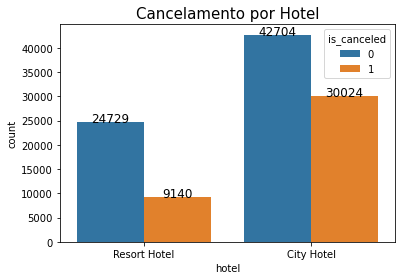

In [45]:
# Comportamento de cancelamentos por Hotel
plot = sns.countplot(data=df, x = 'hotel', hue='is_canceled')
plt.title('Cancelamento por Hotel', size=15)
for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

- Resort Hotel: 26,9% de cancelamentos 
- City Hotel: 41,3% de cancelamentos

O gráfico mostra que existe uma diferença significativa entre as taxas de cancelamento para ambos os hotéis. Dessa forma, faz sentido manter esta feature no modelo.

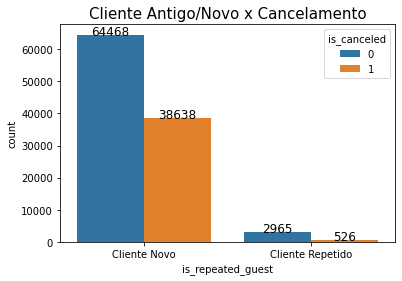

In [46]:
# Comportamento de clientes antigos com cancelamentos de reservas
plot = sns.countplot(data=df, x = 'is_repeated_guest', hue='is_canceled')
plt.title('Cliente Antigo/Novo x Cancelamento', size=15)
ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Cliente Novo', 'Cliente Repetido'])

for i in plot.patches:
    plot.annotate(i.get_height(),
                 (i.get_x() + i.get_width() / 2, i.get_height()),
                 ha = 'center', va = 'baseline', fontsize=12,
                 )

Clientes repetidos tem uma tendência menor em cancelar uma reserva (15%) quando comparado com novos clientes (37,5%).

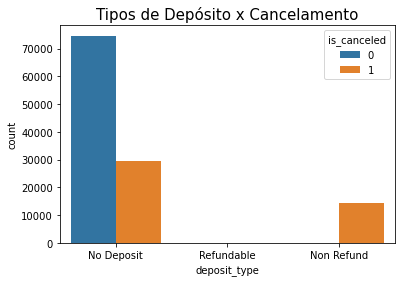

In [19]:
sns.countplot(data = df, x = 'deposit_type',hue='is_canceled')
plt.title('Tipos de Depósito x Cancelamento', size=15)

plt.show()

A informação sobre a existência ou não de um depósito para garantir a reserva parece ser bastante relevante para o modelo.

Quase a totalidade de casos de 'Non Refund' (quando é feito um depósito no valor total do custo de estadia) possui a tendência em ser cancelado.

<a id = '3.5'></a>
#### 3.5 Tratamento de Outliers

<a id = '3.5.1'></a>
##### 3.5.1 Método de Turkey para encontrar e tratar outliers de colunas numéricas

A partir do método de Turkey, encontrarei os limites inferiores e superiores da distribuição de dados das features. Depois farei uma análise em cima dos dados que estiverem abaixo do limite inferior (𝐿𝑖𝑛𝑓 = 𝑄1 − (1.5 ∗ 𝐼𝑄𝑅)) ou acima do limite superior (𝐿𝑠𝑢𝑝 = 𝑄3 + (1.5 ∗ 𝐼𝑄𝑅)) e, se for o caso, excluirei os outliers.

In [20]:
# Função para definir os limites de uma coluna
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude # retornaremos o limite inferior e superior

# Função que vai pegar os limites da função anterior para excluir os outliers.
# Além disso, retornará quantidade de linhas removidas pois se a quantidade for muito grande, pode afetar o modelo.
def excluir_outliers(df, nome_coluna): # df é a base (dataframe)
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup) , :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [21]:
def diagrama_caixa(coluna):
    fig, (ax1,ax2) = plt.subplots(1,2) # ax1 é eixo do 1º gráfico. ax2 é eixo do 2º gráfico
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

Tratamento das colunas com valores:
- lead_time
- stays_in_weekend_nights
- stays_in_week_nights
- adults
- children
- babies
- previous_cancellations
- previous_bookings_not_canceled
- booking_changes
- adr
- total_of_special_requests

C:\Users\joaov\AppData\Local\Temp/ipykernel_6364/468765281.py:5: UserWarning: Attempting to set identical left == right == 2.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_6364/468765281.py:5: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_6364/468765281.py:5: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_6364/468765281.py:5: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\joaov\AppData\Local\Temp/ipykernel_6364/468765281.py:5: UserWarning: Attempting to set identical left == ri

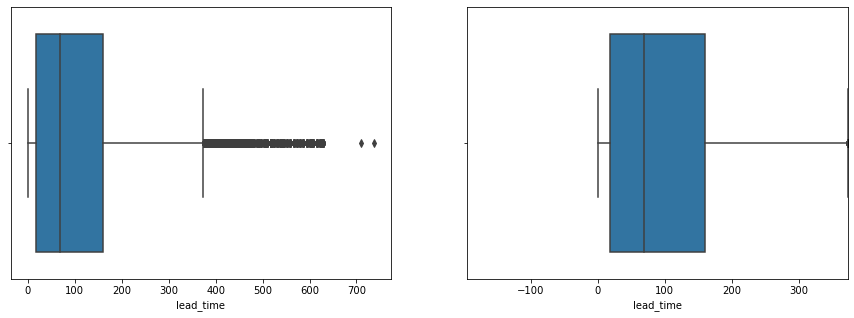

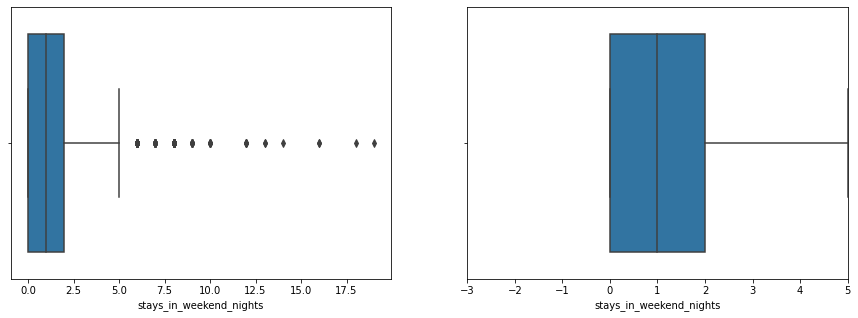

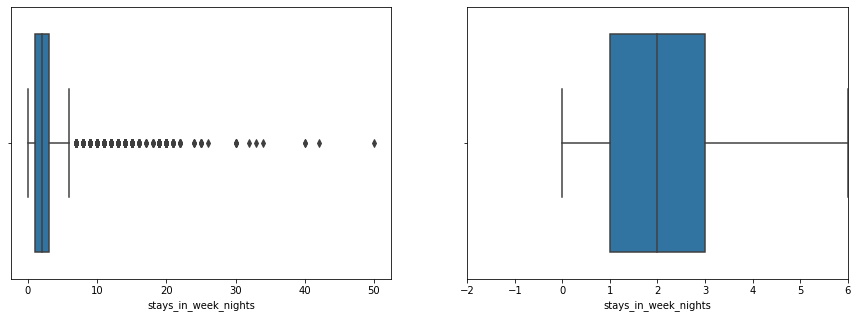

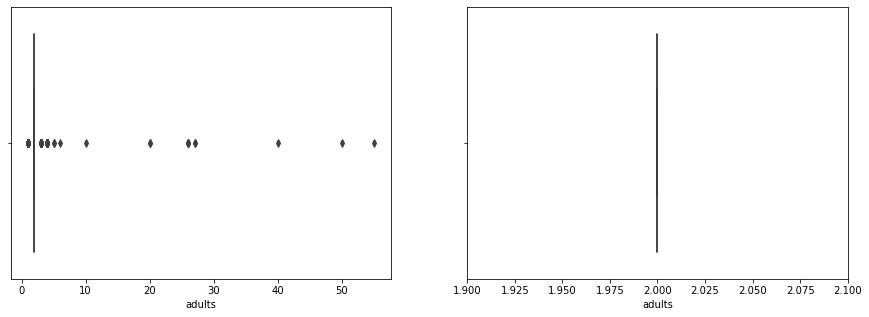

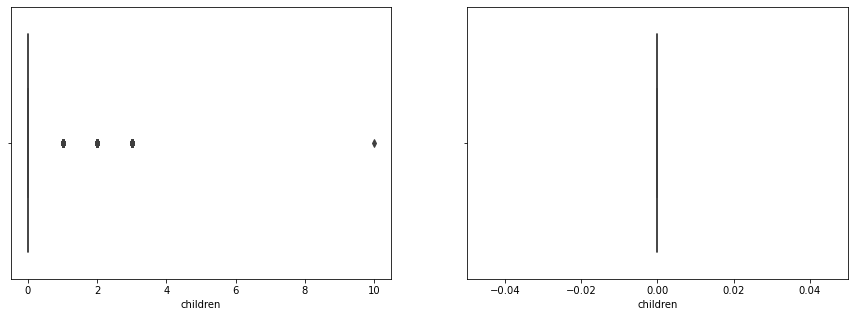

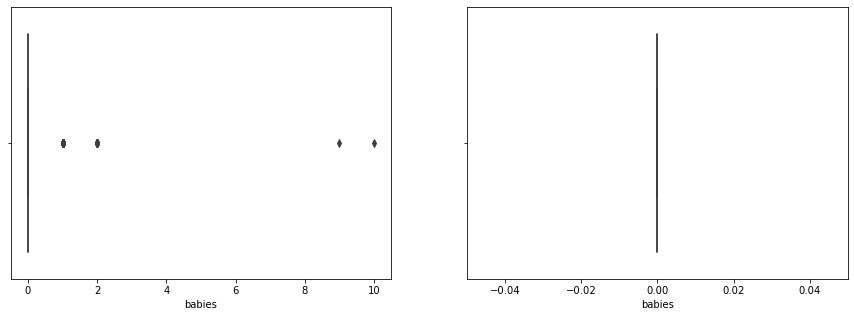

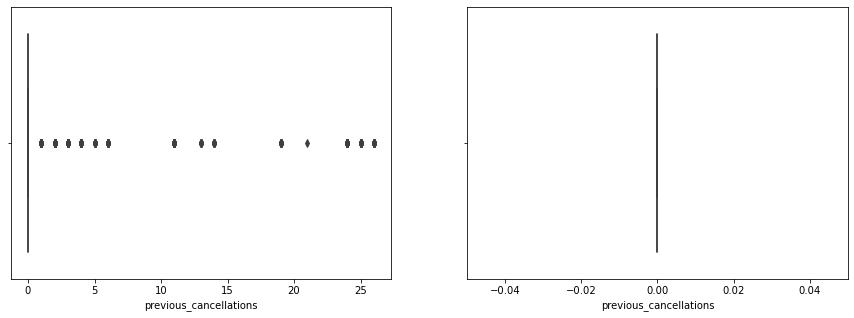

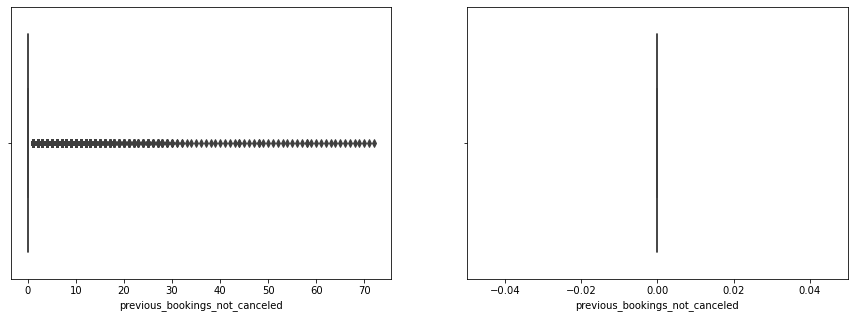

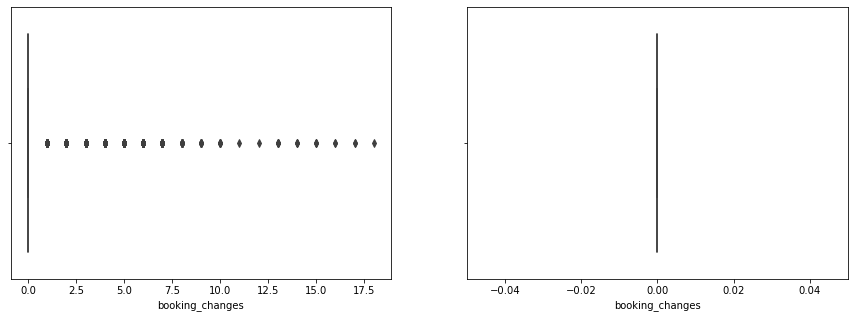

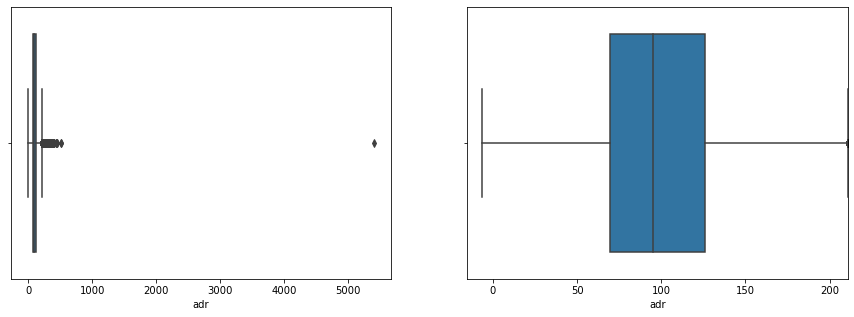

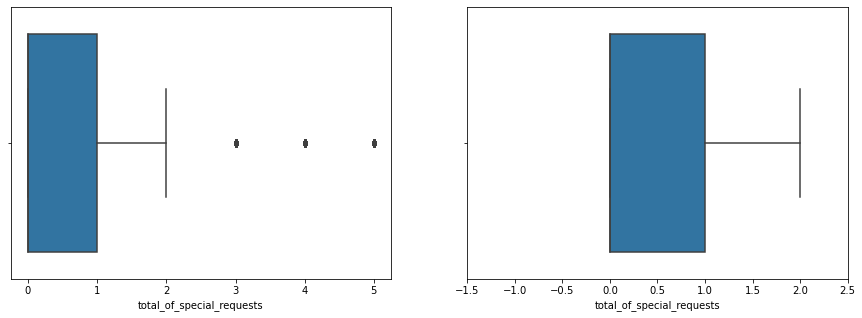

In [22]:
col_valores = ['lead_time','stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'total_of_special_requests']

for i in col_valores:
    diagrama_caixa(df[i])

A partir dos gráficos de boxplot acima, é possível notar que existem colunas com limite inferior e superior iguais: adults, children, babies, previous_cancelations, previous_bookings_not_canceled, booking_changes.

A retirada de outliers dessas colunas faria com que elas perdessem o sentido no modelo, visto que ter apenas um valor na coluna apenas enviesaria a previsão. Em contrapartida, também não pretendo excluir essas colunas visto que todas apresentam correlação significativa com a variável target. Assim, deixarei essas colunas intactas.

Quanto às outras colunas, todas possuem limites inferiores abaixo de 0. Como tais colunas possuem valores positivos, serão apenas retirados outliers acima do limite superior.

In [23]:
# Colunas com limite inferior e superior iguais

print("Limite da coluna 'adults':{}".format(limites(df['adults'])))
print("Limite da coluna 'children': {}".format(limites(df['children'])))
print("Limite da coluna 'babies': {}".format(limites(df['babies'])))
print("Limite da coluna 'previous_cancellations': {}".format(limites(df['previous_cancellations'])))
print("Limite da coluna 'previous_bookings_not_canceled': {}".format(limites(df['previous_bookings_not_canceled'])))
print("Limite da coluna 'booking_changes': {}".format(limites(df['booking_changes'])))

Limite da coluna 'adults':(2.0, 2.0)
Limite da coluna 'children': (0.0, 0.0)
Limite da coluna 'babies': (0.0, 0.0)
Limite da coluna 'previous_cancellations': (0.0, 0.0)
Limite da coluna 'previous_bookings_not_canceled': (0.0, 0.0)
Limite da coluna 'booking_changes': (0.0, 0.0)


In [49]:
# Limites das outras colunas

print("Limite da coluna 'lead_time':{}".format(limites(df['lead_time'])))
print("Limite da coluna 'stays_in_weekend_nights':{}".format(limites(df['stays_in_weekend_nights'])))
print("Limite da coluna 'stays_in_week_nights':{}".format(limites(df['stays_in_week_nights'])))
print("Limite da coluna 'adr':{}".format(limites(df['adr'])))
print("Limite da coluna 'total_of_special_requests':{}".format(limites(df['total_of_special_requests'])))

Limite da coluna 'lead_time':(-3.029228755602774, 2.7886704889156078)
Limite da coluna 'stays_in_weekend_nights':(-4.432057573956486, 4.776054148988598)
Limite da coluna 'stays_in_week_nights':(-3.019375867146238, 2.6135161598964873)
Limite da coluna 'adr':(-2.6477643834906326, 2.5404598137284387)
Limite da coluna 'total_of_special_requests':(-2.920922563722522, 2.903070375640897)


In [24]:
# Retirando outliers da coluna 'lead_time'
df, qtde_linhas_removidas = excluir_outliers(df,'lead_time')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3003 linhas removidas


In [25]:
# Retirando outliers da coluna 'stays_in_weekend_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_weekend_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

255 linhas removidas


In [26]:
# Retirando outliers da coluna 'stays_in_week_nights'
df, qtde_linhas_removidas = excluir_outliers(df,'stays_in_week_nights')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3039 linhas removidas


In [27]:
# Retirando outliers da coluna 'adr'
df, qtde_linhas_removidas = excluir_outliers(df,'adr')
print('{} linhas removidas'.format(qtde_linhas_removidas))

3556 linhas removidas


In [28]:
# Retirando outliers da coluna 'total_of_special_requests'
df, qtde_linhas_removidas = excluir_outliers(df,'total_of_special_requests')
print('{} linhas removidas'.format(qtde_linhas_removidas))

2537 linhas removidas


In [29]:
# Nova estrutura de linhas e colunas do dataframe
df.shape

(106597, 22)

<a id = '3.5.2'></a>
##### 3.5.2 Colunas com texto/categóricas

In [30]:
# Quantidade de categorias existentes por coluna
a = df.select_dtypes(object).columns
for i in a:
    print (i, df[i].nunique())

hotel 2
meal 5
market_segment 8
distribution_channel 5
reserved_room_type 9
deposit_type 3
customer_type 4
data_chegada 793


In [31]:
# Divindo a coluna de 'data_chegada' em ano, mês e dia.
# Faço isso para diminuir o peso de uma única feature, reduzindo a complexidade do modelo.

df['data_chegada'] = pd.to_datetime(df['data_chegada'])

df['ano_chegada'] = df['data_chegada'].dt.year
df['mes_chegada'] = df['data_chegada'].dt.month
df['dia_chegada'] = df['data_chegada'].dt.day

df.drop(['data_chegada'], axis=1, inplace=True)

In [32]:
# Usando o LabelEncoder para padronizar a escala de números utilizada nas colunas de data
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['ano_chegada'] = le.fit_transform(df['ano_chegada'])
df['mes_chegada'] = le.fit_transform(df['mes_chegada'])
df['dia_chegada'] = le.fit_transform(df['dia_chegada'])

In [33]:
# Colunas de categoria do dataset
txt_cols = df.select_dtypes(object).columns

for i in txt_cols:
    print(f"{i}: {df[i].unique()}\n")

hotel: ['Resort Hotel' 'City Hotel']

meal: ['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

reserved_room_type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']

deposit_type: ['No Deposit' 'Refundable' 'Non Refund']

customer_type: ['Transient' 'Contract' 'Transient-Party' 'Group']



Para codificar essas colunas de texto, usarei o método do ONE HOT ENCODER, que é similar ao LabelEncoder, porém divide as colunas em várias outras que representam suas categorias. Essas colunas serão preenchidas apenas com 0 ou 1.

In [34]:
# Criando uma cópia do dataframe original
df_encod = df.copy()

# Encoding a partir do método de variáveis dummies
df_encod = pd.get_dummies(data = df_encod, columns = txt_cols)
df_encod.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,0,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,7,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,13,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0,14,0,2,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


<a id = '4.0'></a>
### 4. Modelo de Previsão

<a id = '4.1'></a>
#### 4.1 Estruturando o Modelo

In [35]:
# Extraindo a variável target do modelo
X = df_encod.drop('is_canceled', axis = 1)
y = df_encod['is_canceled']

X.shape, y.shape

((106597, 52), (106597,))

In [36]:
# Separando conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

Os dados apresentam uma diferença significante de escala entre si. Para evitar que uma feature se predomino sobre outra, aplicarei uma técnica de Feature Scalling chamada Standardization (Normalização).

Neste método, os dados serão redimensionados, garantindo que eles fiquem em forma de uma curva Gaussiana.

In [37]:
# Feature Scalling
scaler = StandardScaler().fit(df[col_valores])
scaler.transform(df[col_valores])
df[col_valores] = scaler.transform(df[col_valores])

In [38]:
modelo_lr = LogisticRegression()
modelo_rf = RandomForestClassifier()
modelo_dt = DecisionTreeClassifier()
modelo_xgb = XGBClassifier()

modelos = {'Logistic Regression': modelo_lr,
          'Random Forest': modelo_rf,
          'Decision Tree': modelo_dt,
          'XGBoost': modelo_xgb}

<a id = '4.2'></a>
#### 4.2 Gerando a previsão

In [39]:
for nome_modelo, modelo in modelos.items():
    # treinar/fit:
    modelo.fit(X_train, y_train)
    # testar/predict:
    previsao = modelo.predict(X_test)
    acc = accuracy_score(y_test, previsao)
    conf = confusion_matrix(y_test, previsao)
    print(f"Precisão do {nome_modelo}: {acc}")
    print(f"Confusion Matrix {nome_modelo}: \n{conf}\n")

C:\Users\joaov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precisão do Logistic Regression: 0.795984990619137
Confusion Matrix Logistic Regression: 
[[15123  1707]
 [ 3730  6090]]

Precisão do Random Forest: 0.8638273921200751
Confusion Matrix Random Forest: 
[[15671  1159]
 [ 2470  7350]]

Precisão do Decision Tree: 0.8226266416510319
Confusion Matrix Decision Tree: 
[[14430  2400]
 [ 2327  7493]]

Precisão do XGBoost: 0.8413883677298312
Confusion Matrix XGBoost: 
[[15599  1231]
 [ 2996  6824]]



O modelo com melhor nota de precisão foi o Random Forest, com cerca de 86% de accuracy score.

Para efeito de melhor visualização, segue um plot exemplo de árvore de decisão feita pelo Random Forest. Plotarei apenas 3 camadas da árvore por conta da quantidade de features existentes no modelo.

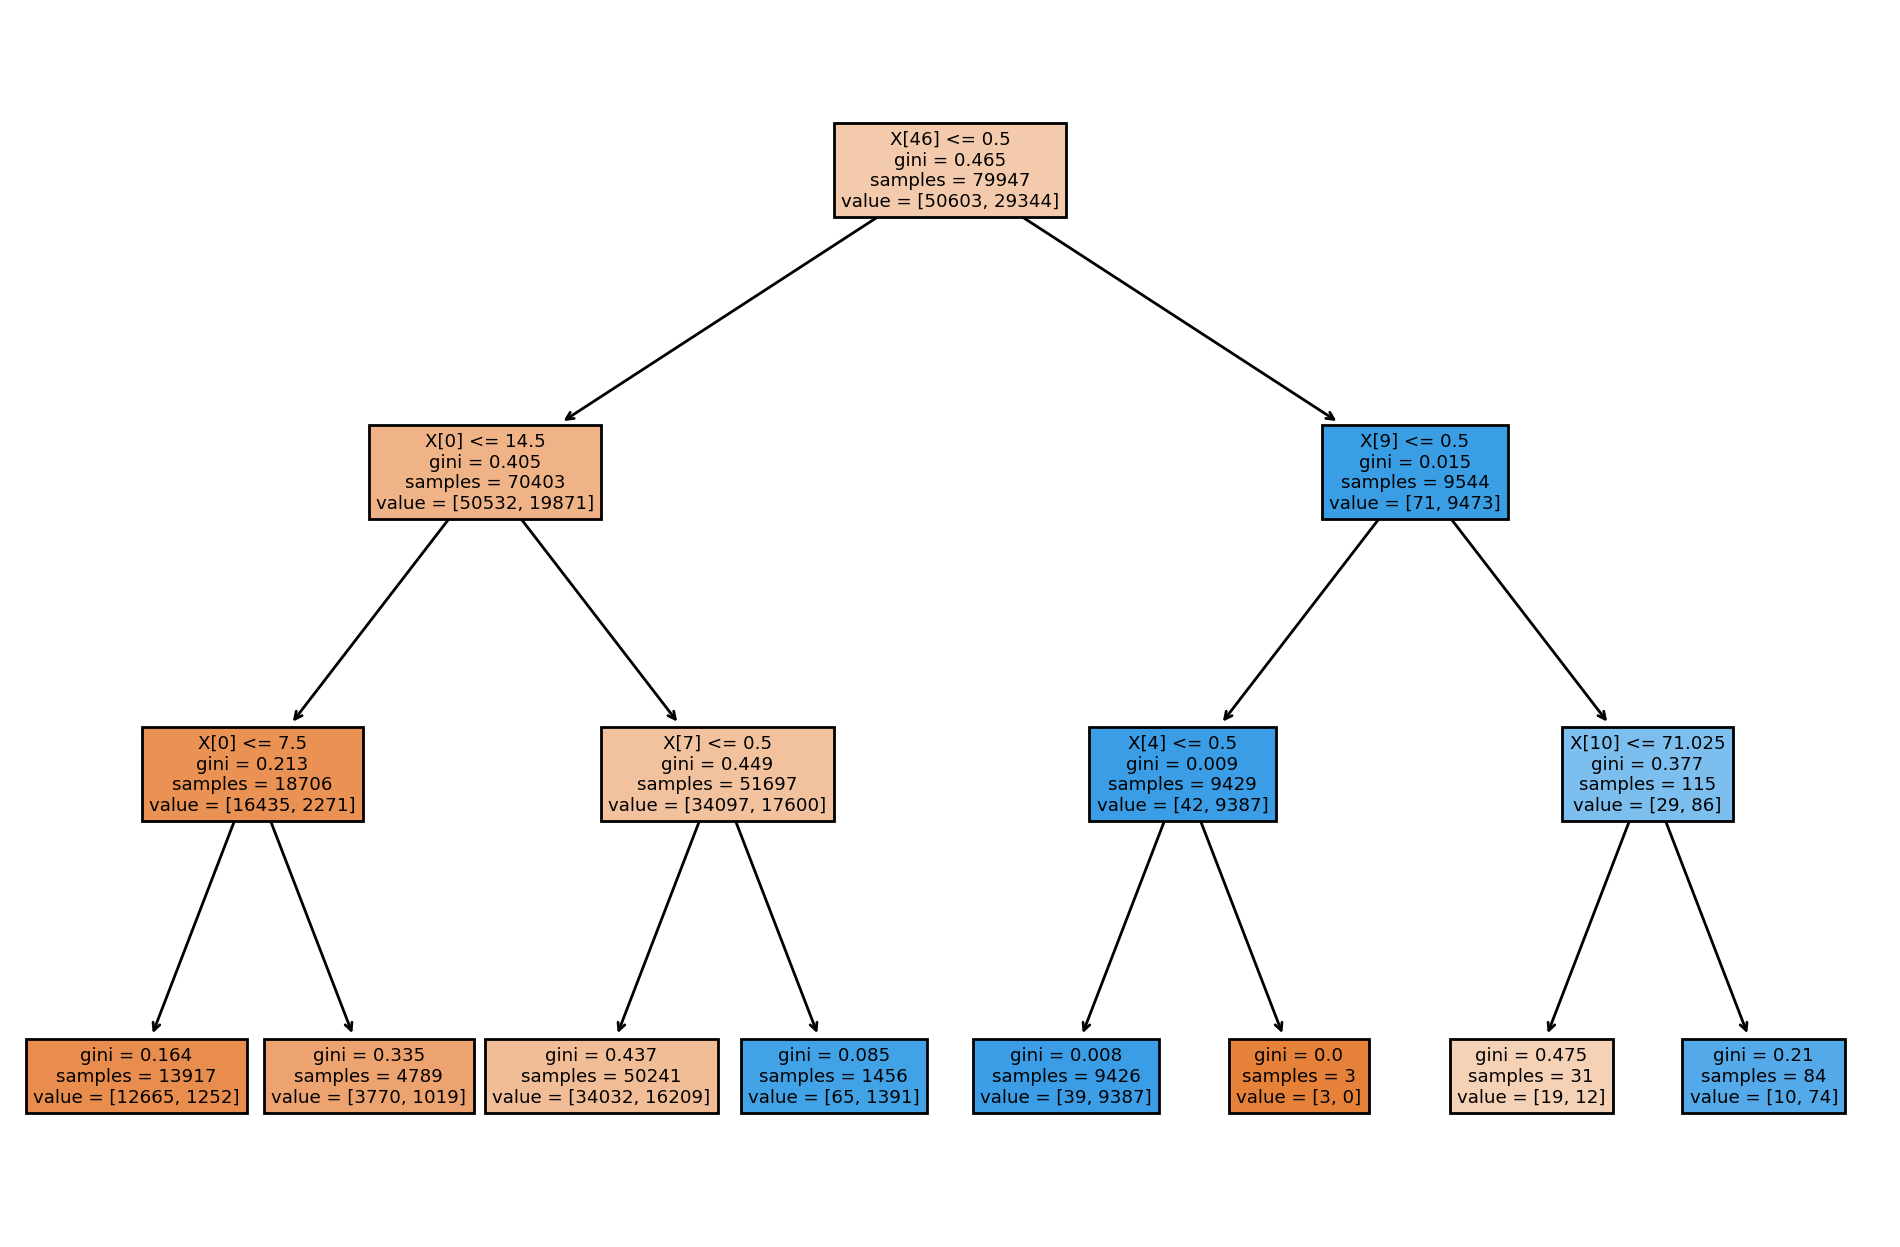

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8), dpi=200)

pruned_dtc = DecisionTreeClassifier(max_depth=3)
pruned_dtc.fit(X_train, y_train)
y_pred_dtc = pruned_dtc.predict(X_test)

plot_tree(pruned_dtc, filled = True);

#### 4.3 Avaliação de importância das features

,0
lead_time,0.163177
adr,0.111695
dia_chegada,0.087971
deposit_type_No Deposit,0.085984
deposit_type_Non Refund,0.080275
mes_chegada,0.058454
total_of_special_requests,0.057913
stays_in_week_nights,0.045935
previous_cancellations,0.039844
stays_in_weekend_nights,0.029026


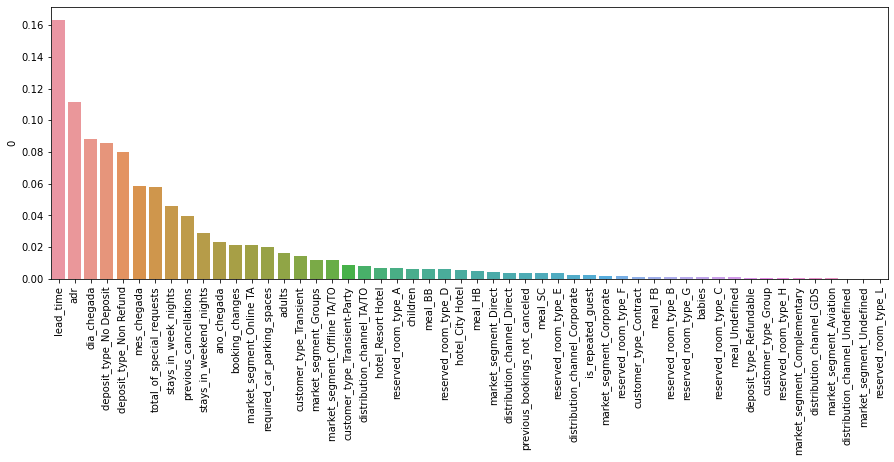

In [51]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

Certas features, como era esperado, tiveram importância relevante no modelo, como: lead time, adr e o tipo de depósito.

Por outro lado, tiveram features com um grau de relevância abaixo de 0,1%. Se a base de dados fosse maior e/ou o modelo menos eficiente, eu provavelmente teria de olhar com cuidado a viabilidade de se manter essas colunas no modelo.

<a id = '5.0'></a>
### 5. Considerações Finais

A partir da exploração de dados do modelo foi possível verificar que a taxa de reservas que são canceladas é consideravelmente alta (37%). Como a motivação da equipe comercial também é formular melhores estratégias comeciais para lidar com cancelamentos, uma dica seria dar maior atenção às variáveis mais importantes. Como por exemplo:
- O **'lead_time'** poderia ser reduzido se os hotéis limitassem o quão para o futuro uma reserva pode ser feita.
- Quanto ao **'adr'**, um estudo de mercado para entender o preço da diária praticado por outros hotéis poderia ajudar a entender se o preço atual está fazendo sentido.
- Percebe-se que, quanto mais personalizada for a estadia **('total_of_special_requests')**, menor a chance de cancelamento. Portanto, um modelo de negócio que dê mais foco em estadias personalizadas também poderia ser benéfico.

De qualquer forma, em qualquer melhoria de processo, **este modelo não deve ser usado como única fonte de informação**. Sugere-se que outras informações como o balanço financeiro, logística e suprimentos também sejam analisadas em conjuntos para a tomada de decisão. 

Por fim, com a aplicação deste modelo, conseguiremos prever o destino de **86%** das reservas feitas, o que ajudará a equipe comercial a focar de forma mais eficiente seus esforços.